 房屋的价格取决于很多因素，就拿美国的房屋来说(咱中国情况特殊)房屋的价格取决于所在的区域,房屋的面积,卧室的数量，卫生间的数量，院子的大小,地下室的面积,车库的数量等等很多变量。在众多的变量中房屋所在区域应该对房屋价格影响最大,但是相同区域的房价,也会因为其他变量的不同而有所差异。今天我们就拿kaggle中的一个案例来分析一下房屋价格和其他变量之间存在的关系,并通过可视化的方式来呈现出这种关系,接着我们要使用ElasticNet和xgboost来创建几个回归模型对价格进行预测,最后我们要评估这些模型的性能,并从中找出表现最好的模型。通过对这个案例数据的分析,可以让大家掌握一些基本的统计学的基础知识如正太分布,均值、标准差、理论分位图(QQ图)、相关系数等知识,这对应想从事数据分析工作的朋友来说有很大的帮助。

# EDA(探索性数据分析)
你可以从这里下载我们的数据，然后加载我们所需要的一些包

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor, plot_importance 
import matplotlib.pyplot as plt 
import seaborn as sns
def ignore_warn(*args, **kwargs):
    pass
import warnings
warnings.warn = ignore_warn
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

如果有发现某些包没有安装,那请在jupyter notebook中使用 !pip install xxx 进行安装。加载完所需要的包以后，我们导入我们的数据:

In [2]:
#加载数据
df = pd.read_csv('./data/house/train.csv')
print(df.shape)
df.head()

(1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

总共有1460条记录，共有81列,其中SalePrice是我们的目标变量，除去SalePrice和Id这两列以外,其余79个变量都是我们的特征变量,这些特征变量的含义在这我就不一一说明了(因为实在太多),大家可以查看kaggle中的Data Description。接下来我们要做数据清洗的工作,因为有很多字段有空值,我们必须要清洗掉这些数据,首先我们要查询一下数据中的空值情况:

In [3]:
#查看变量包含空值的比例
(df.isnull().sum() / len(df)).sort_values(ascending=False)[:20]

PoolQC         0.995
MiscFeature    0.963
Alley          0.938
Fence          0.808
FireplaceQu    0.473
LotFrontage    0.177
GarageCond     0.055
GarageType     0.055
GarageYrBlt    0.055
GarageFinish   0.055
GarageQual     0.055
BsmtExposure   0.026
BsmtFinType2   0.026
BsmtFinType1   0.025
BsmtCond       0.025
BsmtQual       0.025
MasVnrArea     0.005
MasVnrType     0.005
Electrical     0.001
Utilities      0.000
dtype: float64

我们查看了前20个包含空值最多的变量(字段)，其中PoolQC、MiscFeature、Alley、Fence这4个变量所包含空值的比例都在90%和80%以上,它们包含了大量的空值。所以我们要删除这些变量,同时为了便于后续的分析,我们还要同时删除Id字段。

In [4]:
#删除包含空值最多的4个变量和Id
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id'], axis=1, inplace=True)

## 目标变量
SalePrice是我们的目标变量,也是最后我们要预测的变量,所以我们要对它进行深入分析,首先我们要查看SalePrice的数据分布情况。

d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180921.20 and sigma = 79415.29



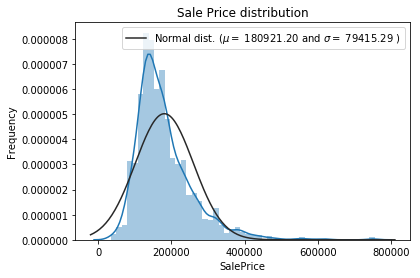

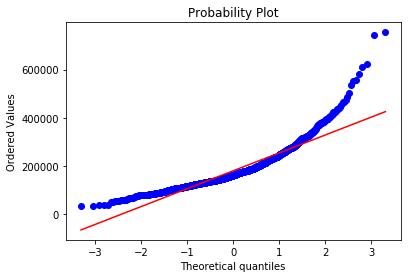

In [5]:
sns.distplot(df['SalePrice'] , fit=norm);

#得到均值和标准差
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')

#画QQ图
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show();

上面那个图是SalePrice的数据分布图(直方图),同时我们用正太分布对它进行拟合,并得到了两个参数均值(μ)和标准差(σ),用肉眼就能看出SalePrice出现右偏(右侧有长尾),严重偏离正态分布。底下的是QQ图(理论分位数图),它的主要作用是判断样本是否近似于某种类型的分布，如果图中的蓝色点偏离了红线,说明数据不服从正太分布(如果蓝点紧紧围绕红线,那就是服从正态分布)。

## 纠偏
当发现SalePrice呈现偏斜的分布以后,我们要对它进行纠偏,我们要数据进行对数化处理,这类似与机器学习中的归一化处理的概念,是一种数据标准化处理的方法。


 mu = 12.02 and sigma = 0.40



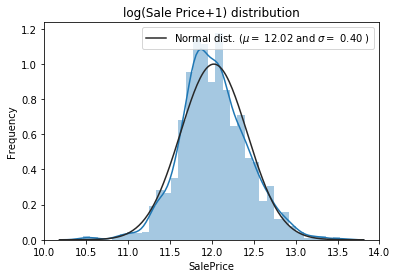

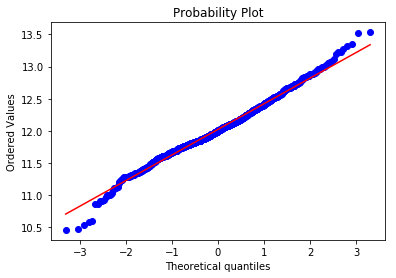

In [6]:
sns.distplot(np.log1p(df['SalePrice']) , fit=norm);

# 纠偏,对数化处理。
(mu, sigma) = norm.fit(np.log1p(df['SalePrice']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#纠偏后再化分布图
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(Sale Price+1) distribution')

#画QQ图
fig = plt.figure()
res = stats.probplot(np.log1p(df['SalePrice']), plot=plt)
plt.show();

经过纠偏处理以后SalePrice基本服从正太分布。

## 特征变量之间的相关性研究
接下来我们要研究的是除SalePrice以外的所有特征变量之间的相关性,我们要画一个所有特征变量(数字型的)之间的相关系数矩阵的热力图:

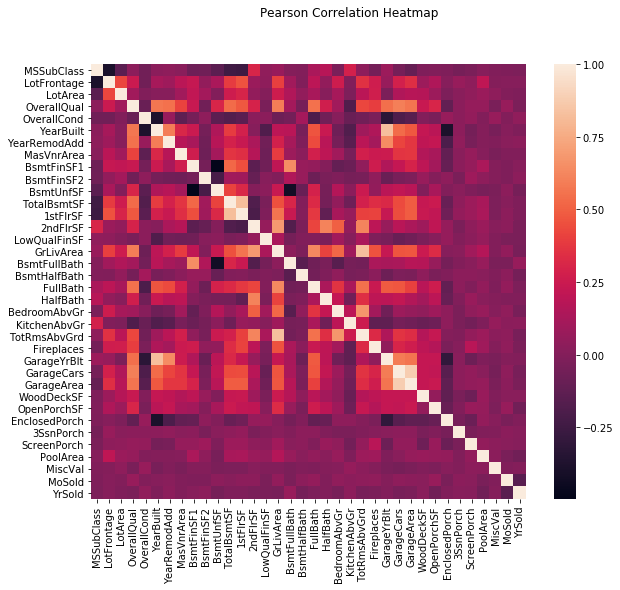

In [7]:
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['SalePrice'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

皮尔森相关系数用来表示两个变量之间存在关联关系的强弱程度(即一个变量发生变化则另外一个变量也随之发生变化),相关系数的取值范围是[-1,1],其中-1表示完全负相关,1表示完全正相关,0表示不相关,在上面的相关系数矩阵中的热图中,色块的颜色越浅(如主对角线呈现白色)表示越呈现正相关越强,颜色越深表示越呈现负相关越强。如上图中YearBuilt和OverallCond这两个变量对应的色块是黑色的,说明有非常强的负相关，YearBuilt表示房屋的建造年份，OverallCond表示总体评级,也是就是房龄越长,总体评级越低。

## 目标变量和特征变量之间的相关性研究
我们完成了特征变量之间的相关性研究以后,接下来我们要进行目标变量SalePrice与我们的特征变量之间的相关性研究

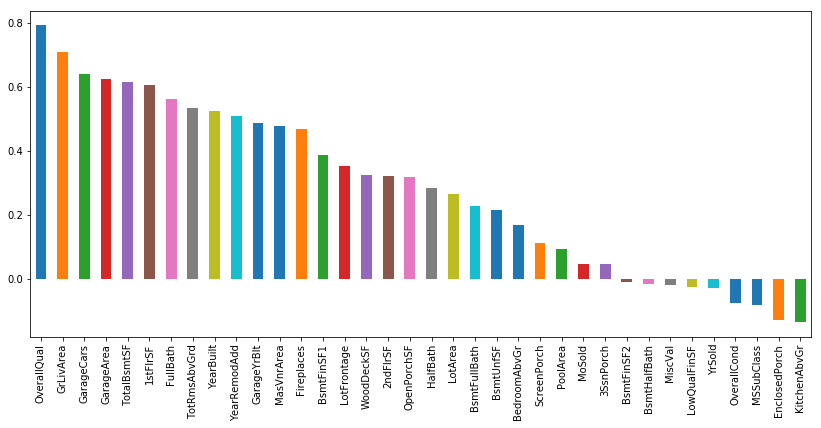

In [8]:
corr_with_sale_price = df.corr()["SalePrice"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.drop("SalePrice").plot.bar()
plt.show();


 我们看到大部分变量与目标变量呈现正相关,有少部分变量呈现负相关。其中OverallQual与目标变量的相关性最大接近80%,我查询了一下OverallQual表示"整体材料和成品质量",这符合常理,房屋的材料和质量越好,房屋的价格应该越高。KitchenAbvGr与目标变量呈现最强的负相关,经过查询KitchenAbvGr表示地面厨房数量,也就是说地面厨房数量越多，房屋价格越低，这是否意味着地面厨房数量越多,房屋的有效使用面积就越小,所以房价就越低?咱没有住过美国的那种独栋别墅,所以只能瞎猜了。下面我们查看一下与目标变量相关性最强的特征变量OverallQual的箱体图

(-0.5, 9.5, 0, 800000)

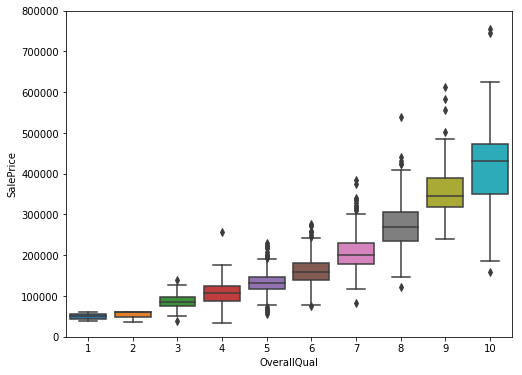

In [9]:
var = 'OverallQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

可以看到随着OverallQual:"整体材料和成品质量"的数值的提高,价格的中位数明显上升，显示出很强的正相关性。

接下来我们查看几个变量的散点图:

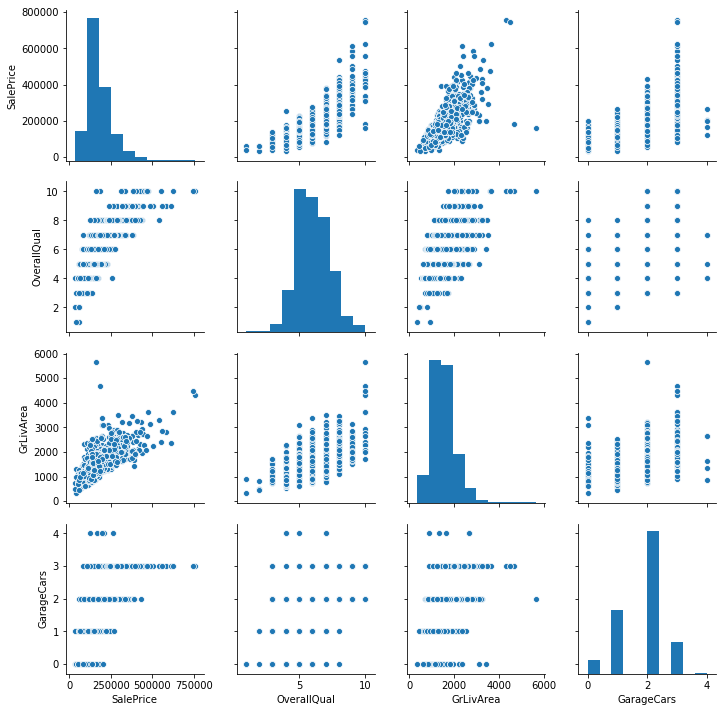

In [10]:
#多变量散点图
sns.pairplot(df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']])
plt.show();

你可以找出哪几个变量之间是正相关的吗？它们的相关性与之前的相关系数矩阵热图是否一致?

# 数据清洗 
上面我们完成了对数据的分析工作,接下来我们要开始清洗数据,以便为后续的模型训练做好准备工作,数据清洗需要完成以下一些工作:

* 对目标变量和特征变量进行纠偏(对数化处理)
* 对分类型变量进行one-hot编码
* 用特征变量的均值来填充空值
* 创建训练集和测试集

In [11]:
print("数据清洗前的特征变量的数量为:",len(df.columns)-1)
#对目标变量进行对数化纠偏
df["SalePrice"] = np.log1p(df["SalePrice"])

#对数值型特征变量进行对数化处理:1.过滤出数值型变量,2.计算偏度,3.对偏度大于0.75的数据进行对数化纠偏
#1.过滤出数值型变量
numeric_feats = df.dtypes[df.dtypes != "object"].index
#2.计算偏度
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
#3.对偏度大于0.75的数据进行对数化纠偏
df[skewed_feats] = np.log1p(df[skewed_feats])
#4.对分类型变量进行one-hot编码,分类型变量会被横向展开为多个变量
df = pd.get_dummies(df)
#用均值填充空值
df = df.fillna(df.mean())

print("数据清洗后的特征变量的数量为:",len(df.columns)-1)
#创建训练集和测试集
X, y = df.drop(['SalePrice'], axis = 1), df['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

数据清洗前的特征变量的数量为: 75
数据清洗后的特征变量的数量为: 275


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log1p
  del sys.path[0]


特征变量的数量,由原来的75个，变成了现在的275个，这是因为我们对分类型变量做了one-hot编码(pd.get_dummies)，经过这样处理以后,原来的分类型变量会被横向展开为多个变量,因此特征变量的总数会增加很多。偏度skew是指偏离正太分布的程度,对于正态分布数据，偏度应约为0.，偏度值> 0意味着数据分布呈现右偏,偏度值<0意味着数据分布呈现左偏。 在统计学上，函数skewtest可用于确定偏度值是否足够接近0(正太分布)。这里我们只对偏度值大于0.75的数据进行纠偏,偏度<0.75的数据是可以容忍的,现实中是不存在100%满足正太分布的数据。所以数据呈现轻微的偏斜是可以容忍的。

# 回归模型

## <a href="https://scikit-learn.org/stable/modules/linear_model.html#elastic-net">ElasticNet</a>(弹性网络)  
* Ridge(岭回归)和Lasso(套索回归)都是常用的正则化的线性回归模型。它们分别使用L2和L1正则化。
* ElasticNet是Ridge(岭回归)和Lasso(套索回归)混合体,它同时使用L2和L1正则化,这种组合允许学习稀疏模型，其中包含了较少的像Lasso回归一样的非零权重，同时仍然保持Ridge的正则化特性。
* 当存在多个彼此相互关联的特征变量时ElasticNet非常有用。
* Skearn的ElasticNetCV类可用于通过交叉验证设置参数alpha(α)和l1_ratio(ρ)。
* ElasticNetCV：通过交叉验证选择最佳模型。  

下面我们使用Skearn的<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html">ElasticNetCV</a>来预测一下我们的目标变量,看看它效果如何。首先我们要对模型进行训练,并拟合出最佳的参数alpha和l1_ratio。

In [12]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)
               
cv_model.fit(X_train, y_train)
print('最佳 alpha: %.8f'%cv_model.alpha_)
print('最佳 l1_ratio: %.3f'%cv_model.l1_ratio_)
print('迭代次数 %d'%cv_model.n_iter_)

最佳 alpha: 0.00013634
最佳 l1_ratio: 0.700
迭代次数 84


下面我们要在训练集和测试集上进行预测和评估，我们使用R^2和RMSE作为评估指标:

In [13]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.9352316018794959
Test r2 score:  0.8300355301028951
Train RMSE: 0.0963
Test RMSE: 0.1604


这里的RMSE实际上是RMSLE（Root Mean Squared Logarithmic Error）,因为我们的目标变量已经被对数化处理了。 这是一篇很好的<a href="https://www.quora.com/What-is-the-difference-between-an-RMSE-and-RMSLE-logarithmic-error-and-does-a-high-RMSE-imply-low-RMSLE/">文章</a>，解释了RMSE和RMSLE之间的区别。

### 提取重要特征

训练完ElasticNetCV后我们可以从中提取对模型来说最重要的特征,也就是特征变量权重最大和最小的变量,我们取最大,最小各30个特征变量:

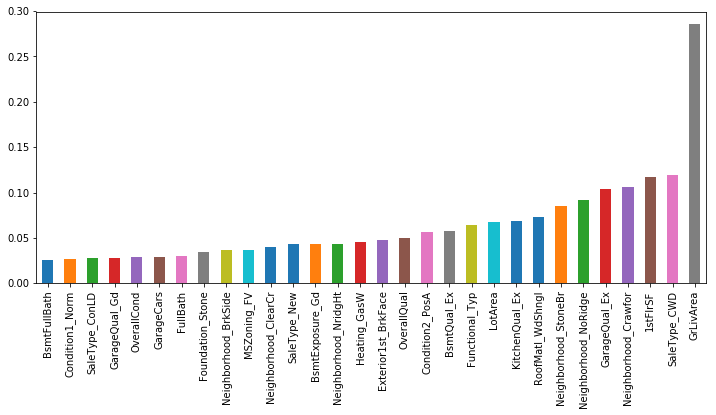

In [14]:
feature_importance = pd.Series(index = X_train.columns, data = cv_model.coef_)
n_selected_features = (feature_importance>0).sum()
feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));

我们看到特征变量GrLivArea的权重最大,GrLivArea表示“房屋地面以上面积”,可见房屋面积越大,房价也越高，这符合常理。下面我们再来看看权重值最小的30个变量:

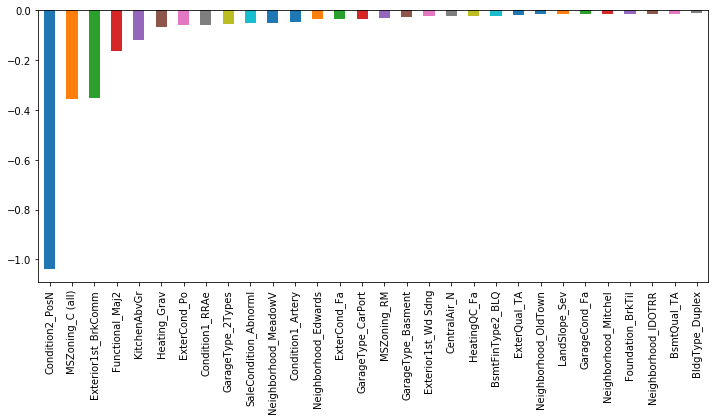

In [15]:
feature_importance.sort_values().head(30).plot(kind = 'bar', figsize = (12,5));

我们看到特征变量Condition2_PosN的权重最小,Condition2是个分类型变量,其中PosN表示“靠近停车场”。这是否意味着停车场附近会有噪声从而影响房价?

因为ElasticNet是Ridge(岭回归)和Lasso(套索回归)混合体,它同时使用L2和L1正则化,这种组合允许学习稀疏模型，那么我们看看有多少特征变量的权重为零,权重为零意味着这些特征对模型来说是无关紧要的。

In [16]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))
zero_weight_features = (feature_importance==0).sum()
print('{0:d} 个权重为零的特征, 所在比例为 of {1:2.2f}%'.format(
    zero_weight_features,(zero_weight_features/len(feature_importance))*100))

162 个权重为零的特征, 所在比例为 of 58.91%


可见有一半以上(58.91%)的特征对模型来说是无关紧要的,它们将被抛弃。

# XGBoost


<a href="https://xgboost.readthedocs.io/en/latest/">XGBoost</a>全名叫（eXtreme Gradient Boosting）极端梯度提升，经常被用在一些Kaggle竞赛中，其效果显著。它是大规模并行boosted tree的工具，它是目前最快最好的开源boosted tree工具包,大家可以参考这篇<a href="https://blog.csdn.net/huibeng7187/article/details/77588001">博客</a>。

下面我们创建基于4个不同参数的Xgboost模型,看看它们效果如何:

In [17]:
#使用默认参数
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

Train r2 score:  0.9546691336034475
Test r2 score:  0.8856612816972917
Train RMSE: 0.0820
Test RMSE: 0.1316


In [18]:
xgb_model2 = XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)

Train r2 score:  0.9678837547788781
Test r2 score:  0.8931330796873692
Train RMSE: 0.0699
Test RMSE: 0.1272


In [19]:
xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

Train r2 score:  0.9479569687487649
Test r2 score:  0.8840040768045745
Train RMSE: 0.0869
Test RMSE: 0.1325


In [20]:
xgb_model4 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                         colsample_bytree=1, max_depth=7, n_jobs=-1)
xgb_model4.fit(X_train,y_train)
y_train_pred4 = xgb_model4.predict(X_train)
y_pred4 = xgb_model4.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred4))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.4f' % train_rmse4)
print('Test RMSE: %.4f' % test_rmse4)

Train r2 score:  0.9869643143887125
Test r2 score:  0.8940290084276306
Train RMSE: 0.0448
Test RMSE: 0.1267


我们可以看到第四个模型在测试集上的R^2成绩最好。并且我们采样默认参数的第一个XGboost模型的表现都要优于ElasticNet。

接下来我们查看一下最优模型xgb_model4 最重要的前30个特征变量

xgboost的特征数量: 201


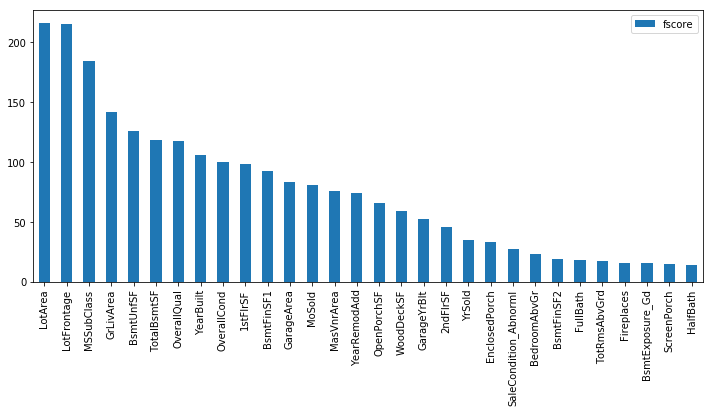

In [21]:

dic = xgb_model4.get_booster().get_fscore()
feature_importance = pd.DataFrame.from_dict(dic,  orient='index', columns=['fscore'])
print('xgboost的特征数量:',len(feature_importance))
feature_importance_plot = feature_importance.sort_values(by="fscore" , ascending=False)[:30]
feature_importance_plot.plot(kind = 'bar', figsize = (12,5))

XGboost的特征数量是201个，可见也有一部分不重要的特征被舍弃了，其中最重要的前5个特征变量是LotArea、LotFrontage、MSSubClass、BsmtUnSF、TotalBsmtSF,它们都不在ElasticNet的前5个重要特征中,看来xgboost的重要特征的认定方法和ElasticNet完全不一样。

下面我们只取这201个特征，再用我们之前的最优模型xgb_model4再进行一下训练和预测，看看模型表现如何:

In [22]:
train_x=df[feature_importance.index]
train_y=df['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)

xgb_model4.fit(X_train,y_train)
y_train_pred4 = xgb_model4.predict(X_train)
y_pred4 = xgb_model4.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred4))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.4f' % train_rmse4)
print('Test RMSE: %.4f' % test_rmse4)

Train r2 score:  0.986369497945745
Test r2 score:  0.902652461231264
Train RMSE: 0.0458
Test RMSE: 0.1214
